##Team members:
- Daniele Kopyshevskiy, 10819304
- Leonardo Liparulo, 10816896
- Jihad Founoun, 10839267
- Silvia Pasini, 10775048
- Mattia Peruzzi, 10769670

### Introduction

In this notebook, we perform the initial preprocessing steps on the RAG12000 dataset to prepare it for downstream analysis and modeling. We load the data, clean and normalize key features, handle missing values, and conduct exploratory checks to ensure data quality. These transformations establish a solid foundation for subsequent tasks such as feature engineering, visualization, and model training.

The RAG12000 dataset contains 12,000 examples designed for Retrieval-Augmented Generation experiments. Each example is structured as a triple:

- Query: the user’s input question or prompt
- Context: the retrieved external document or passage
- Response: the target output to be generated
This format enables seamless integration of retrieval mechanisms into large language model workflows, allowing you to evaluate how external knowledge influences model outputs.

### Environment Setup and Library Imports

Installs required packages, downloads the SpaCy English model and NLTK resources, then imports all libraries needed for data loading, text preprocessing, and visualization.


In [ ]:
!pip install datasets pandas nltk spacy matplotlib seaborn scikit-learn --queit
!python -m spacy download en_core_web_sm

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

import pandas as pd
from datasets import load_dataset
import spacy
from collections import Counter
import re
import string

from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns


nlp = spacy.load('en_core_web_sm')
print("spaCy model loaded.")

# NLTK Stopwords
from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))
print(f"NLTK English stopwords count: {len(nltk_stopwords)}")

# Setup for plots
sns.set(style="whitegrid")


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --queit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
spaCy model loaded.
NLTK English stopwords count: 198


In [ ]:
pip install -U datasets

### Loading the dataset

In [ ]:
dataset_name = "neural-bridge/rag-dataset-12000"

raw_dataset = load_dataset(dataset_name)

if isinstance(raw_dataset, dict):
     df = pd.concat([pd.DataFrame(split) for split in raw_dataset.values()], ignore_index=True)
else:
     df = pd.DataFrame(raw_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

(…)-00000-of-00001-9df3a936e1f63191.parquet:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

(…)-00000-of-00001-af2a9f454ad1b8a3.parquet:   0%|          | 0.00/5.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [ ]:
print("----- Question:", df['question'][0])
print("----- Context:",  df['context'][0])
print("----- Answer:",   df['answer'][0])

----- Question: What is the Berry Export Summary 2028 and what is its purpose?
----- Context: Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.
THE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.
Driven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.
Hort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.
“Australian berr

### Computing and Visualizing Text Statistics

Defines `get_text_stats` to calculate entry counts, and character/word length statistics for a given text column, then plots histograms of character and approximate word lengths across the `question`, `answer`, and `context` columns to inspect distribution before further processing.


--- Initial Statistics (Before Processing) ---

Statistics for 'question':
  Total Entries: 11997
  Non-empty Entries: 11997
  Avg Length (chars): 79.10
  Min Length (chars): 17
  Max Length (chars): 322
  Avg Length (words approx.): 13.56
  Min Length (words approx.): 3
  Max Length (words approx.): 56

Statistics for 'answer':
  Total Entries: 11997
  Non-empty Entries: 11997
  Avg Length (chars): 237.18
  Min Length (chars): 2
  Max Length (chars): 2408
  Avg Length (words approx.): 38.35
  Min Length (words approx.): 1
  Max Length (words approx.): 280

Statistics for 'context':
  Total Entries: 11997
  Non-empty Entries: 11997
  Avg Length (chars): 3437.89
  Min Length (chars): 271
  Max Length (chars): 9156
  Avg Length (words approx.): 581.93
  Min Length (words approx.): 19
  Max Length (words approx.): 1285


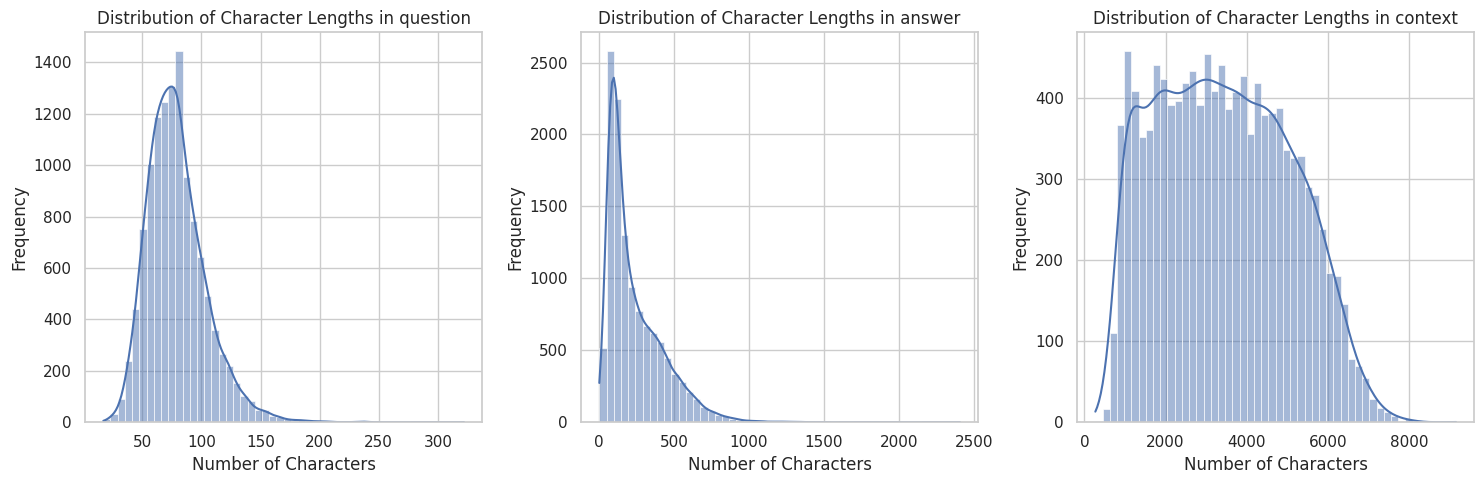

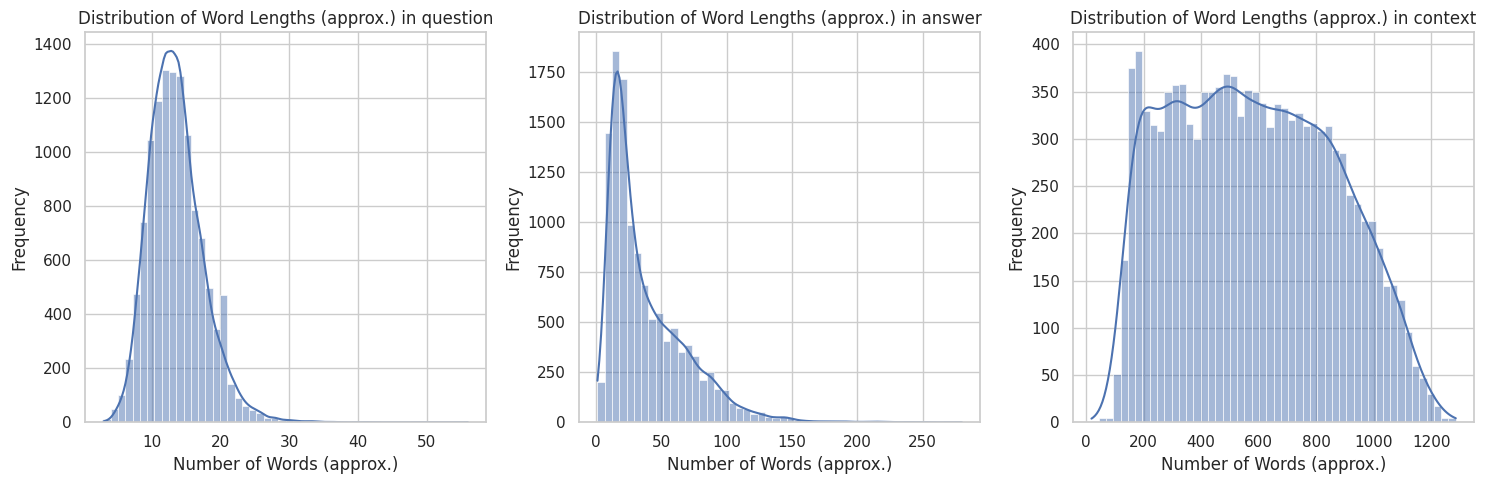

In [ ]:


def get_text_stats(df, column_name):
    """Calculates basic statistics for a text column."""
    stats = {}
    stats['Total Entries'] = len(df[column_name])
    stats['Non-empty Entries'] = df[column_name].astype(bool).sum() # Count non-empty strings
    stats['Avg Length (chars)'] = df[column_name].str.len().mean()
    stats['Min Length (chars)'] = df[column_name].str.len().min()
    stats['Max Length (chars)'] = df[column_name].str.len().max()

    # Word count (simple split by space for a quick estimate before proper tokenization)
    stats['Avg Length (words approx.)'] = df[column_name].str.split().str.len().mean()
    stats['Min Length (words approx.)'] = df[column_name].str.split().str.len().min()
    stats['Max Length (words approx.)'] = df[column_name].str.split().str.len().max()
    return stats

if raw_dataset:
    text_columns = ['question', 'answer', 'context']
    print("--- Initial Statistics (Before Processing) ---")
    for col in text_columns:
        print(f"\nStatistics for '{col}':")
        stats = get_text_stats(df, col)
        for key, value in stats.items():
            print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

    # Visualize distributions of lengths (characters)
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(text_columns):
        plt.subplot(1, 3, i+1)
        sns.histplot(df[col].str.len(), kde=True, bins=50)
        plt.title(f'Distribution of Character Lengths in {col}')
        plt.xlabel('Number of Characters')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(text_columns):
        plt.subplot(1, 3, i+1)
        sns.histplot(df[col].str.split().str.len(), kde=True, bins=50)
        plt.title(f'Distribution of Word Lengths (approx.) in {col}')
        plt.xlabel('Number of Words (approx.)')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### spaCy-Based Text Preprocessing

This cell defines two helper functions:
1. **`preprocess_text_spacy`**: Cleans and tokenizes input text by lowercasing, lemmatizing, and removing stopwords, punctuation, and whitespace using spaCy.
2. **`get_processed_text_string`**: Rejoins a list of tokens into a single cleaned string for downstream processing.


In [ ]:
def preprocess_text_spacy(text):
    """
    Processes text using spaCy:
    1. Lowercases
    2. Tokenizes
    3. Lemmatizes
    4. Removes stopwords
    5. Removes punctuation
    6. Removes spaces
    Returns a list of processed tokens.
    """
    if not isinstance(text, str):
        return []
    doc = nlp(text.lower())
    processed_tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and \
           not token.is_punct and \
           not token.is_space
    ]
    return processed_tokens

def get_processed_text_string(tokens_list):
    """Joins a list of tokens back into a string."""
    return " ".join(tokens_list)

In [ ]:
if raw_dataset:
    # Test the preprocessing function on a sample
    sample_text = df['question'][0] if not df.empty else "This is a sample sentence with stopwords, punctuation! and CAPITALS for testing."
    print(f"Original sample text: {sample_text}")
    processed_sample = preprocess_text_spacy(sample_text)
    print(f"Processed sample tokens: {processed_sample}")
    print(f"Processed sample string: {get_processed_text_string(processed_sample)}")
    processed_sample = preprocess_text_spacy(sample_text)
    print(f"Processed sample tokens: {processed_sample}")
    print(f"Processed sample string: {get_processed_text_string(processed_sample)}")

Original sample text: What is the Berry Export Summary 2028 and what is its purpose?
Processed sample tokens: ['berry', 'export', 'summary', '2028', 'purpose']
Processed sample string: berry export summary 2028 purpose
Processed sample tokens: ['berry', 'export', 'summary', '2028', 'purpose']
Processed sample string: berry export summary 2028 purpose


In [ ]:
if raw_dataset:
    print("--- Applying Preprocessing ---")
    for col in text_columns:
        print(f"Processing column: {col}...")
        df[f'{col}_tokens_processed'] = df[col].apply(preprocess_text_spacy)
        df[f'{col}_text_processed'] = df[f'{col}_tokens_processed'].apply(get_processed_text_string)
        print(f"Finished processing {col}.")

    print("\nDataFrame Head with Processed Columns:")
    print(df[['question', 'question_tokens_processed', 'question_text_processed']].head())

--- Applying Preprocessing ---
Processing column: question...
Finished processing question.
Processing column: answer...
Finished processing answer.
Processing column: context...
Finished processing context.

DataFrame Head with Processed Columns:
                                            question  \
0  What is the Berry Export Summary 2028 and what...   
1  What are some of the benefits reported from ha...   
2  What are the unique features of the Coolands f...   
3  What is the main difference between the Nation...   
4  How did Gunnar Nelson win the fight against Za...   

                           question_tokens_processed  \
0            [berry, export, summary, 2028, purpose]   
1  [benefit, report, have, access, self, supply, ...   
2           [unique, feature, cooland, twitter, app]   
3  [main, difference, national, sample, survey, n...   
4  [gunnar, nelson, win, fight, zak, cumming, ufc...   

                             question_text_processed  
0                  berr

### Statistics and Visualization After Text Processing

This section computes similar statistics as before statistics on the cleaned text


--- Statistics After Processing ---

Statistics for processed 'question':
  Total Entries: 11997
  Avg Length (tokens): 6.76
  Min Length (tokens): 1
  Max Length (tokens): 32
  Avg Length (chars processed): 47.70
  Min Length (chars processed): 4
  Max Length (chars processed): 187

Statistics for processed 'answer':
  Total Entries: 11997
  Avg Length (tokens): 22.35
  Min Length (tokens): 0
  Max Length (tokens): 261
  Avg Length (chars processed): 157.88
  Min Length (chars processed): 0
  Max Length (chars processed): 2213

Statistics for processed 'context':
  Total Entries: 11997
  Avg Length (tokens): 310.95
  Min Length (tokens): 19
  Max Length (tokens): 1095
  Avg Length (chars processed): 2128.97
  Min Length (chars processed): 250
  Max Length (chars processed): 8199


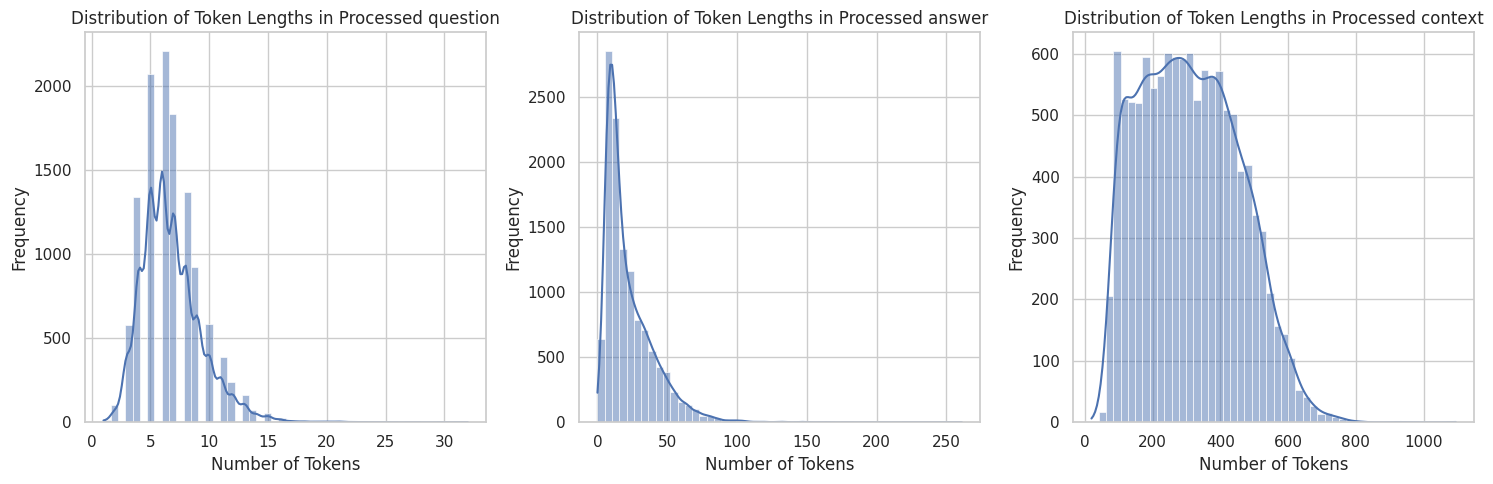

In [ ]:

def get_processed_text_stats(df, column_name_tokens, column_name_text):
    """Calculates statistics for processed text columns."""
    stats = {}
    stats['Total Entries'] = len(df[column_name_tokens])

    # Stats based on token lists
    stats['Avg Length (tokens)'] = df[column_name_tokens].apply(len).mean()
    stats['Min Length (tokens)'] = df[column_name_tokens].apply(len).min()
    stats['Max Length (tokens)'] = df[column_name_tokens].apply(len).max()

    # Stats based on processed text string (character length of joined tokens)
    stats['Avg Length (chars processed)'] = df[column_name_text].str.len().mean()
    stats['Min Length (chars processed)'] = df[column_name_text].str.len().min()
    stats['Max Length (chars processed)'] = df[column_name_text].str.len().max()
    return stats

if raw_dataset:
    print("\n--- Statistics After Processing ---")
    for col in text_columns:
        print(f"\nStatistics for processed '{col}':")
        col_tokens_processed = f'{col}_tokens_processed'
        col_text_processed = f'{col}_text_processed'

        # Ensure the columns exist before trying to get stats
        if col_tokens_processed in df.columns and col_text_processed in df.columns:
            stats = get_processed_text_stats(df, col_tokens_processed, col_text_processed)
            for key, value in stats.items():
                print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")
        else:
            print(f"  Processed columns for '{col}' not found. Skipping stats.")

    # Visualize distributions of token lengths
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(text_columns):
        col_tokens_processed = f'{col}_tokens_processed'
        if col_tokens_processed in df.columns:
            plt.subplot(1, 3, i+1)
            sns.histplot(df[col_tokens_processed].apply(len), kde=True, bins=50)
            plt.title(f'Distribution of Token Lengths in Processed {col}')
            plt.xlabel('Number of Tokens')
            plt.ylabel('Frequency')
        else:
            print(f"Column {col_tokens_processed} not found for plotting.")
    plt.tight_layout()
    plt.show()

### Vocabulary Analysis on Processed Text

Defines `get_vocabulary_stats` to aggregate tokens across all entries, calculate total and unique token counts, and list the top N most frequent tokens; then applies this to each processed column and visualizes the top 20 tokens in the context field. Here we started noticing how the word "context" was particularly present in questions.



--- Vocabulary Analysis (on Processed Text) ---

Vocabulary for 'question':
  Total Tokens: 81094
  Vocabulary Size (Unique Tokens): 17112
  Top 20 Most Common Tokens:
    'context': 1058
    'accord': 939
    'main': 668
    'author': 572
    'purpose': 558
    'mention': 501
    'new': 454
    'feature': 419
    'service': 323
    'offer': 286
    'benefit': 272
    'event': 233
    'game': 229
    'book': 226
    'year': 223
    'type': 209
    'role': 189
    'provide': 187
    'change': 176
    'issue': 175

Vocabulary for 'answer':
  Total Tokens: 268131
  Vocabulary Size (Unique Tokens): 32606
  Top 20 Most Common Tokens:
    'include': 1791
    'new': 973
    'provide': 818
    'service': 780
    'work': 744
    'time': 710
    'year': 701
    'offer': 659
    'author': 650
    'main': 626
    'like': 616
    'need': 597
    'use': 582
    'help': 578
    'people': 575
    'high': 553
    'system': 534
    'day': 498
    'good': 487
    'business': 476

Vocabulary for 'context

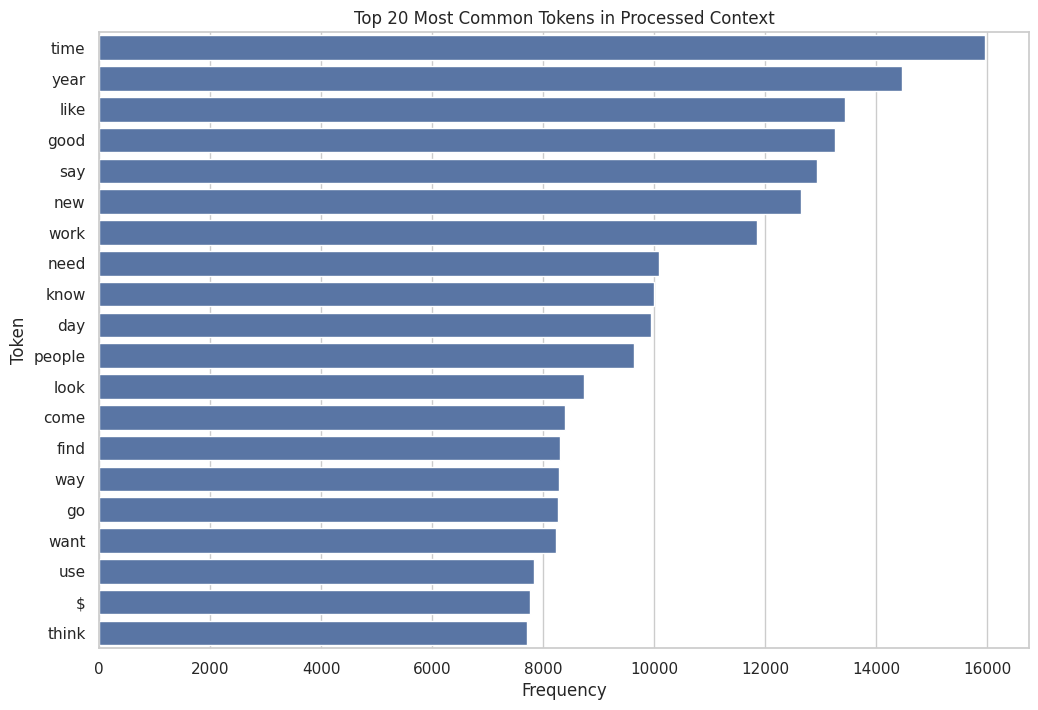

In [ ]:
def get_vocabulary_stats(df, processed_tokens_column, top_n=20):
    """Calculates vocabulary statistics from a column of processed tokens."""
    all_tokens = [token for sublist in df[processed_tokens_column] for token in sublist]

    if not all_tokens:
        return {
            'Total Tokens': 0,
            'Vocabulary Size (Unique Tokens)': 0,
            f'Top {top_n} Most Common Tokens': []
        }

    token_counts = Counter(all_tokens)
    vocab_size = len(token_counts)
    most_common_tokens = token_counts.most_common(top_n)

    return {
        'Total Tokens': len(all_tokens),
        'Vocabulary Size (Unique Tokens)': vocab_size,
        f'Top {top_n} Most Common Tokens': most_common_tokens
    }

if raw_dataset:
    print("\n--- Vocabulary Analysis (on Processed Text) ---")
    for col in text_columns:
        processed_tokens_col_name = f'{col}_tokens_processed'
        if processed_tokens_col_name in df.columns:
            print(f"\nVocabulary for '{col}':")
            vocab_stats = get_vocabulary_stats(df, processed_tokens_col_name)
            for key, value in vocab_stats.items():
                if key.startswith("Top"):
                    print(f"  {key}:")
                    for token, count in value:
                        print(f"    '{token}': {count}")
                else:
                    print(f"  {key}: {value}")
        else:
            print(f"Processed tokens column '{processed_tokens_col_name}' not found for {col}.")

    example_col_tokens = 'context_tokens_processed'
    if example_col_tokens in df.columns:
        all_context_tokens = [token for sublist in df[example_col_tokens] for token in sublist]
        if all_context_tokens:
            context_token_counts = Counter(all_context_tokens)
            top_20_context_tokens = context_token_counts.most_common(20)

            tokens, counts = zip(*top_20_context_tokens)

            plt.figure(figsize=(12, 8))
            sns.barplot(x=list(counts), y=list(tokens))
            plt.title(f'Top 20 Most Common Tokens in Processed Context')
            plt.xlabel('Frequency')
            plt.ylabel('Token')
            plt.show()

### Part-of-Speech Tagging and Analysis

Defines helper functions to extract POS tags with spaCy, then on a random sample:
- **Demonstrates** POS tagging on example texts from each column  
- **Computes** and prints frequency counts of the top POS tags in the sample  
- **Optionally visualizes** the distribution of the top 10 POS tags in the `context` field  



--- Part-of-Speech (POS) Tagging (on Original Text Sample) ---

POS Tagging Examples:

  Example from 'question':
    Original Text: When and where will the Annual Meeting of the Ceramic Society of Japan be held?...
    POS Tags (first 10): [('When', 'SCONJ'), ('and', 'CCONJ'), ('where', 'SCONJ'), ('will', 'AUX'), ('the', 'DET'), ('Annual', 'PROPN'), ('Meeting', 'PROPN'), ('of', 'ADP'), ('the', 'DET'), ('Ceramic', 'PROPN')]

  Example from 'answer':
    Original Text: The Annual Meeting of the Ceramic Society of Japan will be held at the Ohkubo campus of Waseda Unive...
    POS Tags (first 10): [('The', 'DET'), ('Annual', 'PROPN'), ('Meeting', 'PROPN'), ('of', 'ADP'), ('the', 'DET'), ('Ceramic', 'PROPN'), ('Society', 'PROPN'), ('of', 'ADP'), ('Japan', 'PROPN'), ('will', 'AUX')]

  Example from 'context':
    Original Text: - THE MAGAZINE
- NEWS
- NEW PRODUCTS
- TOPICS
- COLUMNS
- RESOURCES
- MULTIMEDIA
- EVENTS
- DIRECTOR...
    POS Tags (first 10): [('-', 'PUNCT'), ('THE', 'DET'), ('

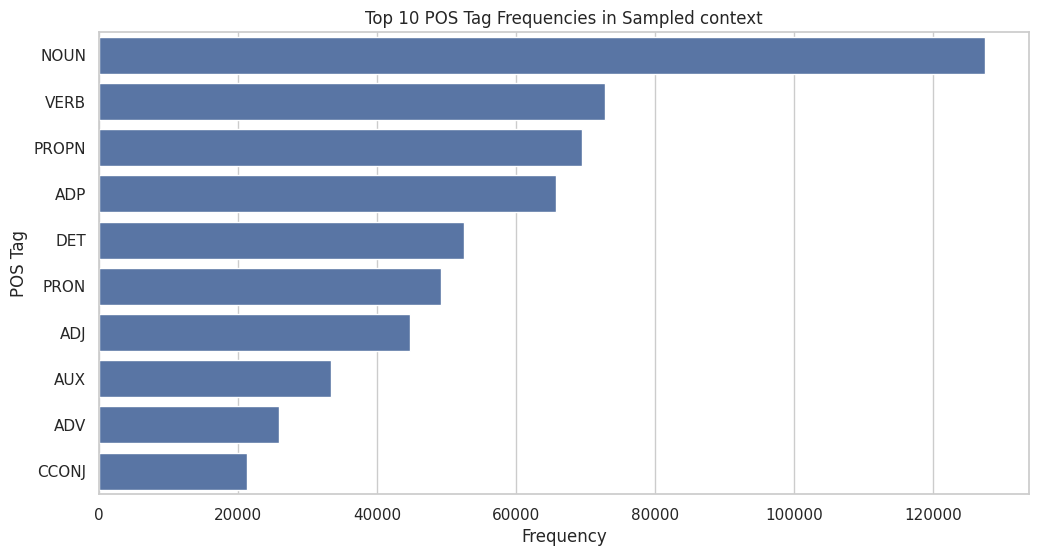

In [ ]:
SAMPLE_SIZE_POS_NER = 1000 #  we can use a smaller sample for demonstration

def get_pos_tags(text):
    """Extracts POS tags from text using spaCy."""
    if not isinstance(text, str):
        return []
    doc = nlp(text) # nb: no lowercasing here to preserve proper nouns, etc.
    return [(token.text, token.pos_) for token in doc if not token.is_space]

def get_pos_tag_frequencies(series):
    """Calculates frequencies of POS tags in a series of texts."""
    all_pos_tags = []
    for text in series:
        doc = nlp(text)
        for token in doc:
            if not token.is_space and not token.is_punct : # exclude spaces and punctuations from freq count
                 all_pos_tags.append(token.pos_)
    return Counter(all_pos_tags)

if raw_dataset:
    print("\n--- Part-of-Speech (POS) Tagging (on Original Text Sample) ---")

    # Take a sample from the DataFrame
    df_sample = df.sample(n=min(SAMPLE_SIZE_POS_NER, len(df)), random_state=42)

    # Demonstrate POS tagging on a few examples
    print("\nPOS Tagging Examples:")
    for i, col in enumerate(text_columns):
        print(f"\n  Example from '{col}':")
        sample_text_for_pos = df_sample[col].iloc[0] if not df_sample.empty else "This is a sample."
        print(f"    Original Text: {sample_text_for_pos[:100]}...") # Print first 100 chars
        pos_tags_example = get_pos_tags(sample_text_for_pos)
        print(f"    POS Tags (first 10): {pos_tags_example[:10]}")

    # Get POS tag frequencies for each column in the sample
    print("\nPOS Tag Frequencies (from sample):")
    pos_tag_explanations = {tag: spacy.explain(tag) for tag in nlp.pipe_labels['tagger'] if spacy.explain(tag)}


    for col in text_columns:
        print(f"\n  Frequencies for '{col}':")
        if not df_sample[col].empty:
            pos_counts = get_pos_tag_frequencies(df_sample[col])
            if pos_counts:
                for tag, count in pos_counts.most_common(10):
                    explanation = spacy.explain(tag)
                    print(f"    {tag} ({explanation if explanation else 'N/A'}): {count}")
            else:
                print("    No POS tags found in the sample for this column.")
        else:
            print(f"    Sample for column '{col}' is empty.")

    # Optional: Visualize POS tag distribution for one column from the sample
    example_col_pos = 'context'
    if not df_sample.empty and example_col_pos in df_sample.columns:
        all_context_pos_tags_sample = []
        for text in df_sample[example_col_pos]:
            doc = nlp(text)
            for token in doc:
                 if not token.is_space and not token.is_punct:
                    all_context_pos_tags_sample.append(token.pos_)

        if all_context_pos_tags_sample:
            context_pos_counts_sample = Counter(all_context_pos_tags_sample)
            top_10_pos = context_pos_counts_sample.most_common(10)

            tags, counts = zip(*top_10_pos)

            plt.figure(figsize=(12, 6))
            sns.barplot(x=list(counts), y=list(tags))
            plt.title(f'Top 10 POS Tag Frequencies in Sampled {example_col_pos}')
            plt.xlabel('Frequency')
            plt.ylabel('POS Tag')
            plt.show()

### Named Entity Recognition on Sample Text

Defines functions to extract and count named entities with spaCy, then on a random sample:
- **Displays** example entities in-line using `displacy`  
- **Computes** and prints the top NER label frequencies for each column  
- **Optionally plots** the distribution of the top 10 entity labels in the `context` field  



--- Named Entity Recognition (NER) (on Original Text Sample) ---

NER Examples with displaCy Visualization:

  Example from 'question':



NER Label Frequencies (from sample):

  Frequencies for 'question':
    ORG (Companies, agencies, institutions, etc.): 396
    PERSON (People, including fictional): 249
    GPE (Countries, cities, states): 161
    DATE (Absolute or relative dates or periods): 125
    CARDINAL (Numerals that do not fall under another type): 92
    NORP (Nationalities or religious or political groups): 34
    ORDINAL ("first", "second", etc.): 34
    LOC (Non-GPE locations, mountain ranges, bodies of water): 32
    WORK_OF_ART (Titles of books, songs, etc.): 30
    FAC (Buildings, airports, highways, bridges, etc.): 26

  Frequencies for 'answer':
    ORG (Companies, agencies, institutions, etc.): 833
    PERSON (People, including fictional): 690
    CARDINAL (Numerals that do not fall under another type): 358
    DATE (Absolute or relative dates or periods): 323
    GPE (Countries, cities, states): 298
    NORP (Nationalities or religious or political groups): 103
    WORK_OF_ART (Titles of books, song

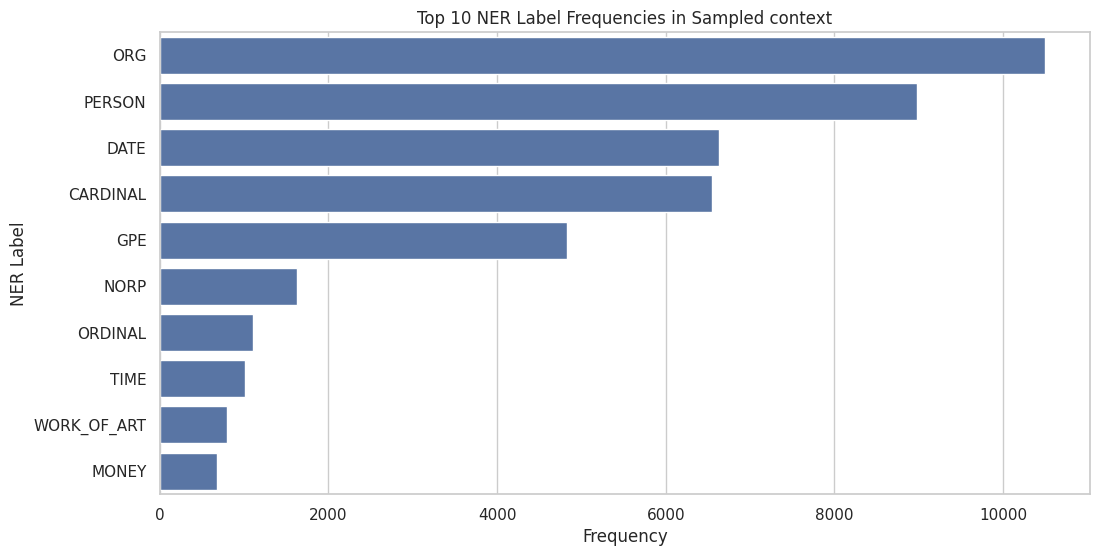

In [ ]:

def get_named_entities(text):
    """Extracts named entities from text using spaCy."""
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def get_ner_frequencies(series):
    """Calculates frequencies of NER labels in a series of texts."""
    all_ner_labels = []
    for text in series:
        doc = nlp(text)
        for ent in doc.ents:
            all_ner_labels.append(ent.label_)
    return Counter(all_ner_labels)

if raw_dataset:
    print("\n--- Named Entity Recognition (NER) (on Original Text Sample) ---")

    # df_sample is already defined from the POS tagging section
    if 'df_sample' not in locals() or df_sample.empty:
        df_sample = df.sample(n=min(SAMPLE_SIZE_POS_NER, len(df)), random_state=42)
        print("Re-created df_sample for NER.")


    # Demonstrate NER on a few examples and visualize with displaCy
    print("\nNER Examples with displaCy Visualization:")

    displacy_options = {"ents": None, "colors": {}}

    for col in text_columns:
        print(f"\n  Example from '{col}':")
        if not df_sample.empty:
            sample_text_for_ner = df_sample[col].iloc[0] # Take the first from sample
            if isinstance(sample_text_for_ner, str) and sample_text_for_ner.strip():
                doc_ner = nlp(sample_text_for_ner)
                if doc_ner.ents:

                    displacy.render(doc_ner, style="ent", jupyter=True, options=displacy_options)
                else:
                    print(f"    No entities found in: {sample_text_for_ner[:100]}...")
            else:
                print("    Sample text is empty or not a string.")
        else:
            print("    df_sample is empty.")

        break


    # Get NER label frequencies for each column in the sample
    print("\nNER Label Frequencies (from sample):")
    for col in text_columns:
        print(f"\n  Frequencies for '{col}':")
        if not df_sample[col].empty:
            ner_counts = get_ner_frequencies(df_sample[col])
            if ner_counts:
                for label, count in ner_counts.most_common(10):
                    explanation = spacy.explain(label)
                    print(f"    {label} ({explanation if explanation else 'N/A'}): {count}")
            else:
                print("    No entities found in the sample for this column.")
        else:
            print(f"    Sample for column '{col}' is empty.")

    #  Visualize NER label distribution for one column from the sample
    example_col_ner = 'context'
    if not df_sample.empty and example_col_ner in df_sample.columns:
        all_context_ner_labels_sample = []
        for text in df_sample[example_col_ner]:
            doc = nlp(text)
            for ent in doc.ents:
                all_context_ner_labels_sample.append(ent.label_)

        if all_context_ner_labels_sample:
            context_ner_counts_sample = Counter(all_context_ner_labels_sample)
            top_10_ner = context_ner_counts_sample.most_common(10)

            if top_10_ner: # Check if there are any entities to plot
                labels, counts = zip(*top_10_ner)

                plt.figure(figsize=(12, 6))
                sns.barplot(x=list(counts), y=list(labels))
                plt.title(f'Top 10 NER Label Frequencies in Sampled {example_col_ner}')
                plt.xlabel('Frequency')
                plt.ylabel('NER Label')
                plt.show()
            else:
                print(f"No entities found to plot for {example_col_ner} in the sample.")

if not raw_dataset:
    print("Final analysis skipped due to dataset loading issues.")

### Conclusion

The notebook completed the following tasks:

- Loaded the RAG dataset and created a Pandas DataFrame  
- Calculated initial statistics (lengths) for **question**, **answer**, and **context** columns  
- Preprocessed text: lowercasing, tokenization, lemmatization, stopword and punctuation removal using spaCy  
- Calculated statistics after text processing  
- Analyzed vocabulary: size and most common tokens for processed texts  
- Performed Part-of-Speech (POS) tagging on a sample of original texts, with examples and frequency counts  
- Performed Named Entity Recognition (NER) on a sample of original texts, with displaCy visualizations and frequency counts  

All requested data analysis tasks (excluding clustering, search, classification) have been demonstrated.  
